In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import auc,roc_auc_score,roc_curve,confusion_matrix
import tensorflow as tf
from keras.preprocessing import sequence
import gc
gc.enable()

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
raw_data = pd.read_csv("gdrive/My Drive/train_data.csv")
resource_data = pd.read_csv("gdrive/My Drive/resources.csv")

In [0]:
temp_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
raw_data = pd.merge(raw_data, temp_data, on='id', how='left')

In [0]:
with open('gdrive/My Drive/glove_vectors','rb') as f:
  model = pickle.load(f)
  glove_words = set(model.keys())

In [6]:
print(raw_data.columns)
print(raw_data['project_subject_categories'].values[3])

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity'],
      dtype='object')
Literacy & Language, Math & Science


<h3>Categories and sucategories processing</h3>

In [0]:
categories = list(raw_data['project_subject_categories'].values)
final_list = []
for i in categories:
  temp = ''
  for j in i.split(','): #splitting categories by comma ','
    j = j.replace(' ','') # replacing the spaces with null string
    j = j.replace('&','_') #replacing all the characters which are not alphabets or numbers with null string
    j = j.replace('The','')#replace 'The' with null string
    j = j.replace('and','_')#replace 'and' with null string
  temp = temp + j + " "#appending the multiple categories with space
  final_list.append(temp.strip())
raw_data['categories'] = final_list
raw_data.drop('project_subject_categories',axis = 1,inplace= True )

In [0]:
subcategories = list(raw_data['project_subject_subcategories'].values)
final_list = []
for i in subcategories:
    temp = ''
    for j in i.split(','): #splitting categories by comma ','
        j = j.replace(' ','') # replacing the spaces with null string
        j = j.replace('&','_') #replacing all the characters which are not alphabets or numbers with null string
        j = j.replace('The','')#replace 'The' with null string
        j = j.replace('and','_')#replace 'and' with null string
    temp = temp + j + " "#appending the multiple categories with space
    final_list.append(temp.strip())
    
raw_data['subcategories'] = final_list
raw_data.drop('project_subject_subcategories',axis = 1,inplace= True)

<h3> Text processing</h3>

In [0]:
raw_data['text'] = raw_data['project_essay_1'].map(str) + " " + raw_data['project_essay_2'].map(str) + " " + raw_data['project_essay_3'].map(str) + " " + raw_data['project_essay_4'].map(str) + " " + raw_data['project_title']

In [0]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't","nan"]

In [0]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
print(raw_data['text'].values[20000])

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore. Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids don't want to sit and do worksheets. They want to learn to count by jumping and playing

In [13]:
from tqdm import tqdm
preprocessed_essays = []
len_essay = []
# tqdm is for printing the status bar
for sentence in tqdm(raw_data['text'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    len_essay.append(len(sent.split()))
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
print(max(len_essay))

100%|██████████| 109248/109248 [01:07<00:00, 1619.07it/s]

536


In [14]:
numbers = []
for sentence in tqdm(raw_data['project_resource_summary'].values):
    temp = []
    x = re.search('(\d+)',sentence)
    if x != None:
        temp.append(x.group(0))
    numbers.append(len(temp))

100%|██████████| 109248/109248 [00:00<00:00, 228897.02it/s]


<h3>Preparing data</h3>

In [15]:
print(raw_data.columns)

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity', 'categories', 'subcategories', 'text'],
      dtype='object')


In [0]:
raw_data.drop(['id','teacher_id','project_essay_1','project_essay_2','project_essay_3','project_essay_4','text','project_title','project_resource_summary'],axis = 1,inplace = True)
raw_data.drop(raw_data.columns[raw_data.columns.str.contains('unnamed',case = False)],axis = 1,inplace=True)
raw_data['text'] = preprocessed_essays
raw_data['resources_numbers'] = numbers
Y = raw_data['project_is_approved']
raw_data.drop('project_is_approved',axis=1,inplace=True)

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(raw_data,Y,test_size = 0.2,stratify=Y)
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,test_size = 0.25,stratify=y_train)

In [18]:
print(x_train.shape)
print(x_cv.shape)
print(x_test.shape)

(65548, 11)
(21850, 11)
(21850, 11)


In [0]:
with open('train_data.pkl','wb') as f:
    pickle.dump([x_train,y_train],f)
    
with open('cv_data.pkl','wb') as f:
    pickle.dump([x_cv,y_cv],f)
    
with open('test_data.pkl','wb') as f:
    pickle.dump([x_test,y_test],f)

In [0]:
with open('train_data.pkl','rb') as f:
    x_train,y_train = pickle.load(f)
    
with open('cv_data.pkl','rb') as f:
    x_cv,y_cv = pickle.load(f)
    
with open('test_data.pkl','rb') as f:
    x_test,y_test = pickle.load(f)

In [4]:
from keras.utils import np_utils
y_train_new = np_utils.to_categorical(y_train)
y_cv_new = np_utils.to_categorical(y_cv)
y_test_new = np_utils.to_categorical(y_test)

print(y_train_new.shape)

(65548, 2)


<h3> featurizing categorial variables using frequency ranking.</h3>

In [5]:
x = Counter(x_train['school_state'].values)
print(x)
print()
names = list(x.keys())
count = []
for name in names:
    count.append(x[name])
k = np.argsort(count)
final = []
for i in range(len(names)):
    final.append(names[k[i]])

final = final[::-1]
print(final)
print(len(final))

state_train = []
for i in tqdm(x_train['school_state'].values):
    state_train.append(final.index(i))

state_cv = []
for i in tqdm(x_cv['school_state'].values):
    state_cv.append(final.index(i))
    
state_test = []
for i in tqdm(x_test['school_state'].values):
    state_test.append(final.index(i))
    
state_train = np.array(state_train)
state_cv = np.array(state_cv)
state_test = np.array(state_test)

100%|██████████| 21850/21850 [00:00<00:00, 1117792.15it/s]

Counter({'CA': 9264, 'TX': 4429, 'NY': 4365, 'FL': 3665, 'NC': 3095, 'IL': 2600, 'GA': 2385, 'SC': 2330, 'MI': 1900, 'PA': 1879, 'IN': 1557, 'MO': 1512, 'OH': 1477, 'LA': 1432, 'MA': 1427, 'WA': 1416, 'NJ': 1352, 'OK': 1343, 'AZ': 1298, 'VA': 1233, 'WI': 1085, 'UT': 1055, 'AL': 1044, 'TN': 1030, 'CT': 1000, 'MD': 914, 'NV': 846, 'MS': 822, 'OR': 763, 'KY': 760, 'MN': 730, 'CO': 648, 'AR': 627, 'ID': 427, 'KS': 386, 'IA': 383, 'NM': 337, 'DC': 327, 'HI': 304, 'ME': 290, 'WV': 287, 'NH': 228, 'AK': 224, 'DE': 197, 'NE': 193, 'SD': 182, 'RI': 158, 'MT': 152, 'ND': 94, 'WY': 52, 'VT': 44})

['CA', 'TX', 'NY', 'FL', 'NC', 'IL', 'GA', 'SC', 'MI', 'PA', 'IN', 'MO', 'OH', 'LA', 'MA', 'WA', 'NJ', 'OK', 'AZ', 'VA', 'WI', 'UT', 'AL', 'TN', 'CT', 'MD', 'NV', 'MS', 'OR', 'KY', 'MN', 'CO', 'AR', 'ID', 'KS', 'IA', 'NM', 'DC', 'HI', 'ME', 'WV', 'NH', 'AK', 'DE', 'NE', 'SD', 'RI', 'MT', 'ND', 'WY', 'VT']
51


In [6]:
x_train['teacher_prefix'] = x_train['teacher_prefix'].fillna('None')
x_cv['teacher_prefix'] = x_cv['teacher_prefix'].fillna('None')
x_test['teacher_prefix'] = x_test['teacher_prefix'].fillna('None')

x = Counter(x_train['teacher_prefix'].values)
print(x)
print()
names = list(x.keys())
count = []
for name in names:
    count.append(x[name])
k = np.argsort(count)
final = []
for i in range(len(names)):
    final.append(names[k[i]])

final = final[::-1]
print(final)
print(len(final))

prefix_train = []
for i in tqdm(x_train['teacher_prefix'].values):
    prefix_train.append(final.index(i))

prefix_cv = []
for i in tqdm(x_cv['teacher_prefix'].values):
    prefix_cv.append(final.index(i))
    
prefix_test = []
for i in tqdm(x_test['teacher_prefix'].values):
    prefix_test.append(final.index(i))
    
prefix_train = np.array(prefix_train)
prefix_cv = np.array(prefix_cv)
prefix_test = np.array(prefix_test)

100%|██████████| 21850/21850 [00:00<00:00, 1570321.66it/s]

Counter({'Mrs.': 34296, 'Ms.': 23424, 'Mr.': 6427, 'Teacher': 1392, 'Dr.': 8, 'None': 1})

['Mrs.', 'Ms.', 'Mr.', 'Teacher', 'Dr.', 'None']
6


In [7]:
x = Counter(x_train['categories'].values)
print(x)
print()
names = list(x.keys())
count = []
for name in names:
    count.append(x[name])
k = np.argsort(count)
final = []
for i in range(len(names)):
    final.append(names[k[i]])

final = final[::-1]
print(final)
print(len(final))

categories_train = []
for i in tqdm(x_train['categories'].values):
    categories_train.append(final.index(i))

categories_cv = []
for i in tqdm(x_cv['categories'].values):
    if i in final:
        categories_cv.append(final.index(i))
    else:
        categories_cv.append(-1)
    
categories_test = []
for i in tqdm(x_test['categories'].values):
    if i in final:
        categories_test.append(final.index(i))
    else:
        categories_test.append(-1)
        
categories_train = np.array(categories_train)
categories_cv = np.array(categories_cv)
categories_test = np.array(categories_test)

100%|██████████| 21850/21850 [00:00<00:00, 1327542.12it/s]

Counter({'Math_Science': 19941, 'Literacy_Language': 18232, 'SpecialNeeds': 7912, 'Health_Sports': 6847, 'Music_Arts': 6115, 'AppliedLearning': 3512, 'History_Civics': 2150, 'Care_Hunger': 839})

['Math_Science', 'Literacy_Language', 'SpecialNeeds', 'Health_Sports', 'Music_Arts', 'AppliedLearning', 'History_Civics', 'Care_Hunger']
8


In [8]:
x = Counter(x_train['subcategories'].values)
print(x)
print()
names = list(x.keys())
count = []
for name in names:
    count.append(x[name])
k = np.argsort(count)
final = []
for i in range(len(names)):
    final.append(names[k[i]])

final = final[::-1]
print(final)
print(len(final))

subcategories_train = []
for i in tqdm(x_train['subcategories'].values):
    subcategories_train.append(final.index(i))

subcategories_cv = []
for i in tqdm(x_cv['subcategories'].values):
    if i in final:
        subcategories_cv.append(final.index(i))
    else:
        subcategories_cv.append(-1)
    
subcategories_test = []
for i in tqdm(x_test['subcategories'].values):
    if i in final:
        subcategories_test.append(final.index(i))
    else:
        subcategories_test.append(-1)
        
subcategories_train = np.array(subcategories_train)
subcategories_cv = np.array(subcategories_cv)
subcategories_test = np.array(subcategories_test)

100%|██████████| 21850/21850 [00:00<00:00, 1233187.23it/s]

Counter({'Mathematics': 15627, 'Literacy': 9464, 'Literature_Writing': 8166, 'SpecialNeeds': 7912, 'Health_Wellness': 3972, 'VisualArts': 3809, 'Health_LifeScience': 1505, 'AppliedSciences': 1485, 'TeamSports': 1335, 'EnvironmentalScience': 1324, 'Other': 1209, 'Music': 1193, 'PerformingArts': 1113, 'SocialSciences': 1099, 'Care_Hunger': 839, 'EarlyDevelopment': 777, 'NutritionEducation': 776, 'Gym_Fitness': 764, 'History_Geography': 760, 'College_CareerPrep': 561, 'ParentInvolvement': 359, 'ESL': 316, 'ForeignLanguages': 286, 'Extracurricular': 263, 'CharacterEducation': 237, 'FinancialLiteracy': 181, 'CommunityService': 106, 'Civics_Government': 60, 'Economics': 50})

['Mathematics', 'Literacy', 'Literature_Writing', 'SpecialNeeds', 'Health_Wellness', 'VisualArts', 'Health_LifeScience', 'AppliedSciences', 'TeamSports', 'EnvironmentalScience', 'Other', 'Music', 'PerformingArts', 'SocialSciences', 'Care_Hunger', 'EarlyDevelopment', 'NutritionEducation', 'Gym_Fitness', 'History_Geograph

In [9]:
x = Counter(x_train['project_grade_category'].values)
print(x)
print()
names = list(x.keys())
count = []
for name in names:
    count.append(x[name])
k = np.argsort(count)
final = []
for i in range(len(names)):
    final.append(names[k[i]])

final = final[::-1]
print(final)
print(len(final))

grade_train = []
for i in tqdm(x_train['project_grade_category'].values):
    grade_train.append(final.index(i))

grade_cv = []
for i in tqdm(x_cv['project_grade_category'].values):
    grade_cv.append(final.index(i))
    
grade_test = []
for i in tqdm(x_test['project_grade_category'].values):
    grade_test.append(final.index(i))
    
grade_train = np.array(grade_train)
grade_cv = np.array(grade_cv)
grade_test = np.array(grade_test)

100%|██████████| 21850/21850 [00:00<00:00, 1355402.53it/s]

Counter({'Grades PreK-2': 26503, 'Grades 3-5': 22397, 'Grades 6-8': 10076, 'Grades 9-12': 6572})

['Grades PreK-2', 'Grades 3-5', 'Grades 6-8', 'Grades 9-12']
4


In [6]:
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences

t = Tokenizer()
t.fit_on_texts(x_train['text'].values)
vocab = len(t.word_counts) + 1
print(vocab)

train_sequence = t.texts_to_sequences(x_train['text'].values)
print(train_sequence[2])
cv_sequence = t.texts_to_sequences(x_cv['text'].values)
test_sequence = t.texts_to_sequences(x_test['text'].values)

train_sequence = np.array(pad_sequences(train_sequence,maxlen=600))
cv_sequence = np.array(pad_sequences(cv_sequence,maxlen=600))
test_sequence = np.array(pad_sequences(test_sequence,maxlen=600))

47251
[2268, 23, 3457, 4130, 23, 3053, 4407, 3712, 23, 8, 556, 420, 502, 312, 1, 23, 3457, 477, 601, 2268, 123, 574, 118, 13508, 582, 123, 650, 222, 252, 204, 159, 1839, 831, 4337, 22, 2800, 3055, 3162, 343, 4338, 14569, 996, 211, 813, 667, 368, 456, 2698, 2651, 721, 49, 262, 7236, 4130, 51, 3, 1, 70, 6573, 438, 178, 104, 103, 2188, 302, 2, 254, 48, 4783, 820, 290, 3, 477, 11, 495, 10, 1404, 159, 2, 14, 160, 30, 3695, 12, 1, 298, 5333, 1165, 990, 4039, 88, 5, 101, 184, 30, 3695, 11, 81, 101, 70, 1165, 29, 1908, 18, 159, 11, 102, 106, 2011, 726, 1077, 2, 40, 3695, 1, 49, 65, 861, 101, 4055, 159]


In [7]:
embedding_matrix = np.zeros((vocab,300))
for word,i in tqdm(t.word_index.items()):
    if word in glove_words:
        embedding_matrix[i] = model[word]
    else:
        embedding_matrix[i] = np.zeros(300)

100%|██████████| 47250/47250 [00:00<00:00, 332046.34it/s]


<h3>Standardizing numerical features</h3>

In [0]:
scaler = StandardScaler()
price_train = scaler.fit_transform(x_train['price'].values.reshape(-1,1))
price_cv = scaler.transform(x_cv['price'].values.reshape(-1,1))
price_test = scaler.transform(x_test['price'].values.reshape(-1,1))

In [0]:
scaler = StandardScaler()
quantity_train = scaler.fit_transform(x_train['quantity'].values.reshape(-1,1))
quantity_cv = scaler.transform(x_cv['quantity'].values.reshape(-1,1))
quantity_test = scaler.transform(x_test['quantity'].values.reshape(-1,1))

In [0]:
scaler = StandardScaler()
posted_train = scaler.fit_transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
posted_cv = scaler.transform(x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
posted_test = scaler.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

In [0]:
scaler = StandardScaler()
num_train = scaler.fit_transform(x_train['resources_numbers'].values.reshape(-1,1))
num_cv = scaler.transform(x_cv['resources_numbers'].values.reshape(-1,1))
num_test = scaler.transform(x_test['resources_numbers'].values.reshape(-1,1))


In [0]:
x_train_new = pd.DataFrame()
x_train_new['state'] = state_train
x_train_new['grade'] = grade_train
x_train_new['categories'] = categories_train
x_train_new['subcategories'] = subcategories_train
x_train_new['prefix'] = prefix_train
x_train_new['price'] = price_train
x_train_new['quantity'] = quantity_train
x_train_new['posted'] = posted_train
x_train_new['resource'] = num_train

x_cv_new = pd.DataFrame()
x_cv_new['state'] = state_cv
x_cv_new['grade'] = grade_cv
x_cv_new['categories'] = categories_cv
x_cv_new['subcategories'] = subcategories_cv
x_cv_new['prefix'] = prefix_cv
x_cv_new['price'] = price_cv
x_cv_new['quantity'] = quantity_cv
x_cv_new['posted'] = posted_cv
x_cv_new['resource'] = num_cv

x_test_new = pd.DataFrame()
x_test_new['state'] = state_test
x_test_new['grade'] = grade_test
x_test_new['categories'] = categories_test
x_test_new['subcategories'] = subcategories_test
x_test_new['prefix'] = prefix_test
x_test_new['price'] = price_test
x_test_new['quantity'] = quantity_test
x_test_new['posted'] = posted_test
x_test_new['resource'] = num_test

<h3> Model 1 </h3>

In [0]:
from keras.layers import Input,Embedding,Flatten,Dense,concatenate,LSTM,Dropout
from keras.models import Model
#tf.keras.layers.
# School state encoding
state_input = Input(shape=(1,))
state_embed = Embedding(51+1,3,input_length=1)(state_input)
state_flatten = Flatten()(state_embed)

# project grade encoding
grade_input = Input(shape=(1,))
grade_embed = Embedding(4+1,3,input_length=1)(grade_input)
grade_flatten = Flatten()(grade_embed)

# Teacher prefix encoding
prefix_input = Input(shape=(1,))
prefix_embed = Embedding(6+1,3,input_length=1)(prefix_input)
prefix_flatten = Flatten()(prefix_embed)

# categories encoding
categories_input = Input(shape=(1,))
categories_embed = Embedding(50+1,3,input_length=1)(categories_input)
categories_flatten = Flatten()(categories_embed)
#,dtype = 'float32'
# subcategories encoding
subcategories_input = Input(shape=(1,))
subcategories_embed = Embedding(387+1,3,input_length=1)(subcategories_input)
subcategories_flatten = Flatten()(subcategories_embed)

# numerical features encoding
num_input = Input(shape=(4,))
num_dense = Dense(5,input_shape=(4,),activation = 'relu')(num_input)

# text feature encoding
text_input = Input(shape=(600,))
text_embed = Embedding(vocab,300,weights=[embedding_matrix],trainable = False ,input_length=None)(text_input)
text_lstm = LSTM(100,input_shape=(600,300),activation='relu',return_sequences= True )(text_embed)
text_flatten = Flatten()(text_lstm)

In [43]:
from keras.models import Model
concat = concatenate([text_flatten,state_flatten,grade_flatten,categories_flatten,subcategories_flatten,prefix_flatten,num_dense])
dense1 = Dense(320,activation='relu')(concat)
dropout1 = Dropout(0.7)(dense1)
dense2 = Dense(160,activation='relu')(dropout1)
dropout2 = Dropout(0.7)(dense2)
dense3 = Dense(80,activation='relu')(dropout2)
output = Dense(2,activation='softmax')(dense3)

nn = Model(input=[text_input,state_input,grade_input,categories_input,subcategories_input,prefix_input,num_input],output=[output])

print(nn.summary())

W0829 17:04:42.308383 140462514567040 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 600)          0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 600, 300)     14175300    input_21[0][0]                   
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 1)            0                                            
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  # Remove the CWD from sys.path while we load stuff.


In [0]:
#how to use auc as metric in keras: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
# How to early stop if val_loss is increasing: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
 
tensorboard =TensorBoard(log_dir="Model1")

In [0]:
import keras
import numpy as np
from sklearn.metrics import auc

#Using auc as metric: https://datascience.stackexchange.com/questions/13746/how-to-define-a-custom-performance-metric-in-keras/20192#20192
import sklearn.metrics as sklm
#How to get roc-auc curve:https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
# Create own earlystopping:https://stackoverflow.com/questions/37293642/how-to-tell-keras-stop-training-based-on-loss-value
class Metrics(keras.callbacks.Callback):
    def __init__(self,training_data):
      self.x = training_data[0]
      self.y = training_data[1]
      super(keras.callbacks.Callback, self).__init__()
      
      
    def on_train_begin(self, logs={}):
        self.cv_auc = []
        self.train_auc = []
        self.max_auc = -1
        
        
    def on_epoch_end(self, epoch, logs={}):
        train_score = np.asarray(self.model.predict(self.x,batch_size=2048,verbose=1))
        #train_predict = np.round(train_score)
        train_targ = self.y
        print("Train AUC score",sklm.roc_auc_score(train_targ,train_score))
        self.train_auc.append(sklm.roc_auc_score(train_targ,train_score))
        
        cv_score = np.asarray(self.model.predict(self.validation_data[:7],batch_size=2048,verbose=1))
        #cv_predict = np.round(cv_score)
        cv_targ = self.validation_data[7]
        print("Validation AUC score",sklm.roc_auc_score(cv_targ,cv_score))
        self.cv_auc.append(sklm.roc_auc_score(cv_targ,cv_score))
        
        if self.max_auc < self.cv_auc[-1]:
          temp = self.model.save_weights('Model1.pkl',overwrite=True)
          self.max_auc = self.cv_auc[-1]
          print("Changed")
        else:
          print("No change")
            
            #print("Epoch:",epoch,"EarlyStopped by CV_AUC")
            #self.model.stop_training = True

        return
      
auc_metric = Metrics(training_data=([train_sequence,x_train_new['state'],x_train_new['grade'],x_train_new['categories'],x_train_new['subcategories'],x_train_new['prefix'],x_train_new[['price','quantity','posted','resource']]],y_train_new))

In [46]:
nn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
result = nn.fit([train_sequence,x_train_new['state'],x_train_new['grade'],x_train_new['categories'],x_train_new['subcategories'],x_train_new['prefix'],x_train_new[['price','quantity','posted','resource']]],y_train_new,batch_size=2048,callbacks=[tensorboard,auc_metric],epochs = 20,verbose=1,validation_data=([cv_sequence,x_cv_new['state'],x_cv_new['grade'],x_cv_new['categories'],x_cv_new['subcategories'],x_cv_new['prefix'],x_cv_new[['price','quantity','posted','resource']]],y_cv_new))

Train on 65548 samples, validate on 21850 samples
Epoch 1/20
65548/65548 [==============================] - 31s 473us/step
Train AUC score 0.6666515006952844
21850/21850 [==============================] - 10s 469us/step
Validation AUC score 0.6545336318916452
Changed
Epoch 2/20
65548/65548 [==============================] - 31s 472us/step
Train AUC score 0.7222910298736125
21850/21850 [==============================] - 10s 470us/step
Validation AUC score 0.7091812556781815
Changed
Epoch 3/20
65548/65548 [==============================] - 31s 471us/step
Train AUC score 0.744347210446216
21850/21850 [==============================] - 10s 469us/step
Validation AUC score 0.7250562323232614
Changed
Epoch 4/20
65548/65548 [==============================] - 31s 470us/step
Train AUC score 0.7477725385965821
21850/21850 [==============================] - 10s 471us/step
Validation AUC score 0.7258797851140356
Changed
Epoch 5/20
65548/65548 [==============================] - 31s 469us/step
Train 

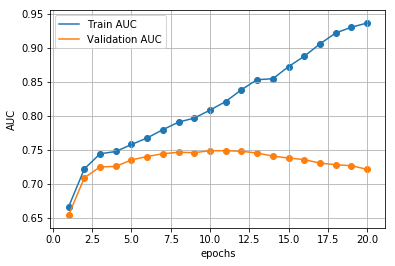

In [47]:
k = [i for i in range(1,len(auc_metric.cv_auc)+1)]
plt.plot(k,auc_metric.train_auc,label="Train AUC")
plt.scatter(k,auc_metric.train_auc)
plt.plot(k,auc_metric.cv_auc,label="Validation AUC")
plt.scatter(k,auc_metric.cv_auc)
plt.xlabel('epochs')
plt.ylabel('AUC')
plt.grid()
plt.legend()
plt.show()

In [48]:
nn.load_weights('Model1.pkl')
score = nn.evaluate([test_sequence,x_test_new['state'],x_test_new['grade'],x_test_new['categories'],x_test_new['subcategories'],x_test_new['prefix'],x_test_new[['price','quantity','posted','resource']]],y_test_new,verbose=1,batch_size=2048)
y_test_hat = nn.predict([test_sequence,x_test_new['state'],x_test_new['grade'],x_test_new['categories'],x_test_new['subcategories'],x_test_new['prefix'],x_test_new[['price','quantity','posted','resource']]],verbose=1,batch_size=2048)

print("Test Accuracy",score[1])
print("Test loss",score[0])
print("Test AUC",roc_auc_score(y_test,y_test_hat[:,1]))

21850/21850 [==============================] - 10s 475us/step
Test Accuracy 0.8486041191513533
Test loss 0.4211515887651072
Test AUC 0.7521418171263071


<h3> Model 2 <h3>

<h3><font color=red>

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=10)
tfidf.fit(x_train['text'])
print(len(tfidf.vocabulary_))

13935


In [0]:
vals = tfidf.idf_
words = tfidf.get_feature_names()

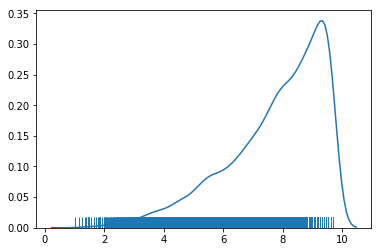

In [12]:
import seaborn as sns
temp_vals = (np.sort(vals))
sns.distplot(temp_vals, hist=False, rug=True)
plt.show()

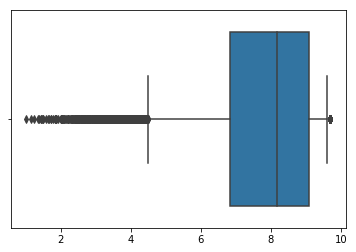

In [13]:
sns.boxplot(temp_vals,whis = [5,95])

In [14]:
for i in range(0,101,5):
  print("The {}th percentile is {}".format(i,np.percentile(temp_vals,i)))

The 0th percentile is 1.0074880335180072
The 5th percentile is 4.482181341817483
The 10th percentile is 5.355961573572401
The 15th percentile is 5.9232466063227
The 20th percentile is 6.438064053276699
The 25th percentile is 6.827863044640464
The 30th percentile is 7.163299548388144
The 35th percentile is 7.455824245315713
The 40th percentile is 7.721105381078328
The 45th percentile is 7.947418507153817
The 50th percentile is 8.158727600821024
The 55th percentile is 8.35288361526198
The 60th percentile is 8.564192708929188
The 65th percentile is 8.723257403558875
The 70th percentile is 8.912499403197405
The 75th percentile is 9.094820959991358
The 80th percentile is 9.257339889489133
The 85th percentile is 9.38250303244314
The 90th percentile is 9.525603876083812
The 95th percentile is 9.605646583757348
The 100th percentile is 9.69265796074698


In [15]:
for i in range(20,31,1):
  print("The {}th percentile is {}".format(i,np.percentile(temp_vals,i)))

The 20th percentile is 6.438064053276699
The 21th percentile is 6.518399201367585
The 22th percentile is 6.605756300054694
The 23th percentile is 6.68787585167307
The 24th percentile is 6.753015153844031
The 25th percentile is 6.827863044640464
The 26th percentile is 6.908769683253264
The 27th percentile is 6.978565445188806
The 28th percentile is 7.040697226295812
The 29th percentile is 7.106946611837013
The 30th percentile is 7.163299548388144


In [16]:
for i in range(70,81,1):
  print("The {}th percentile is {}".format(i,np.percentile(temp_vals,i)))

The 70th percentile is 8.912499403197405
The 71th percentile is 8.9550590176162
The 72th percentile is 8.999510780187034
The 73th percentile is 8.999510780187034
The 74th percentile is 9.046030795821926
The 75th percentile is 9.094820959991358
The 76th percentile is 9.094820959991358
The 77th percentile is 9.14611425437891
The 78th percentile is 9.14611425437891
The 79th percentile is 9.200181475649185
The 80th percentile is 9.257339889489133


Here, we can see that the idf values of the IQR (25-75 percentile) range lies approximately between 6.8 to 9.

In [17]:
#see how many words lie between idf values:https://stackoverflow.com/questions/9560207/how-to-count-values-in-a-certain-range-in-a-numpy-array
def between(a,start):
  return a[(start < a) & (a < i+1)].size

for i in range(1,10):
  print("Number of idf values between {} and {} is {}".format(i,i+1,between(temp_vals,i)))


Number of idf values between 1 and 2 is 25
Number of idf values between 2 and 3 is 117
Number of idf values between 3 and 4 is 318
Number of idf values between 4 and 5 is 593
Number of idf values between 5 and 6 is 1133
Number of idf values between 6 and 7 is 1621
Number of idf values between 7 and 8 is 2674
Number of idf values between 8 and 9 is 3709
Number of idf values between 9 and 10 is 3745


Hence we take words which have an idf value between 2 to 8 because we are leaving out the most common words with low idf values and Leaving out very rare words which might not hava a glove vector representation.

In [18]:
final_words = []
for i in tqdm(range(len(words))):
  if (vals[i] >=2) and (vals[i] <=8):
    final_words.append(words[i])

100%|██████████| 13935/13935 [00:00<00:00, 504593.99it/s]


In [19]:
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences

t = Tokenizer()
t.fit_on_texts(x_train['text'].values)
vocab = len(t.word_counts) + 1
print(vocab)

train_sequence = t.texts_to_sequences(x_train['text'].values)
print(train_sequence[2])
cv_sequence = t.texts_to_sequences(x_cv['text'].values)
test_sequence = t.texts_to_sequences(x_test['text'].values)

train_sequence = pad_sequences(train_sequence,maxlen=600)
cv_sequence = pad_sequences(cv_sequence,maxlen=600)
test_sequence = pad_sequences(test_sequence,maxlen=600)

47251
[2268, 23, 3457, 4130, 23, 3053, 4407, 3712, 23, 8, 556, 420, 502, 312, 1, 23, 3457, 477, 601, 2268, 123, 574, 118, 13508, 582, 123, 650, 222, 252, 204, 159, 1839, 831, 4337, 22, 2800, 3055, 3162, 343, 4338, 14569, 996, 211, 813, 667, 368, 456, 2698, 2651, 721, 49, 262, 7236, 4130, 51, 3, 1, 70, 6573, 438, 178, 104, 103, 2188, 302, 2, 254, 48, 4783, 820, 290, 3, 477, 11, 495, 10, 1404, 159, 2, 14, 160, 30, 3695, 12, 1, 298, 5333, 1165, 990, 4039, 88, 5, 101, 184, 30, 3695, 11, 81, 101, 70, 1165, 29, 1908, 18, 159, 11, 102, 106, 2011, 726, 1077, 2, 40, 3695, 1, 49, 65, 861, 101, 4055, 159]


In [20]:
embedding_matrix = np.zeros((vocab,300))
for word,i in tqdm(t.word_index.items()):
    if (word in glove_words) and (word in final_words):
        embedding_matrix[i] = model[word]
    else:
        embedding_matrix[i] = np.zeros(300)

100%|██████████| 47250/47250 [00:05<00:00, 8525.66it/s]


In [21]:
from keras.layers import Input,Embedding,Flatten,Dense,concatenate,LSTM,Dropout
from keras.models import Model
#tf.keras.layers.
# School state encoding
state_input = Input(shape=(1,))
state_embed = Embedding(51+1,3,input_length=1)(state_input)
state_flatten = Flatten()(state_embed)

# project grade encoding
grade_input = Input(shape=(1,))
grade_embed = Embedding(4+1,3,input_length=1)(grade_input)
grade_flatten = Flatten()(grade_embed)

# Teacher prefix encoding
prefix_input = Input(shape=(1,))
prefix_embed = Embedding(6+1,3,input_length=1)(prefix_input)
prefix_flatten = Flatten()(prefix_embed)

# categories encoding
categories_input = Input(shape=(1,))
categories_embed = Embedding(50+1,3,input_length=1)(categories_input)
categories_flatten = Flatten()(categories_embed)
#,dtype = 'float32'
# subcategories encoding
subcategories_input = Input(shape=(1,))
subcategories_embed = Embedding(387+1,3,input_length=1)(subcategories_input)
subcategories_flatten = Flatten()(subcategories_embed)

# numerical features encoding
num_input = Input(shape=(4,))
num_dense = Dense(5,input_shape=(4,),activation = 'relu')(num_input)

# text feature encoding
text_input = Input(shape=(600,))
text_embed = Embedding(vocab,300,weights=[embedding_matrix],trainable = False ,input_length=None)(text_input)
text_lstm = LSTM(100,input_shape=(600,300),activation='relu',return_sequences= True )(text_embed)
text_flatten = Flatten()(text_lstm)

W0829 19:59:22.581775 140380302292864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 19:59:22.599394 140380302292864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 19:59:22.606252 140380302292864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 19:59:22.731657 140380302292864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0829 19:59:22.733173 1403803022

In [22]:
from keras.models import Model
concat = concatenate([text_flatten,state_flatten,grade_flatten,categories_flatten,subcategories_flatten,prefix_flatten,num_dense])
dense1 = Dense(320,activation='relu')(concat)
dropout1 = Dropout(0.7)(dense1)
dense2 = Dense(160,activation='relu')(dropout1)
dropout2 = Dropout(0.7)(dense2)
dense3 = Dense(80,activation='relu')(dropout2)
output = Dense(2,activation='softmax')(dense3)

nn = Model(input=[text_input,state_input,grade_input,categories_input,subcategories_input,prefix_input,num_input],output=[output])

print(nn.summary())

W0829 19:59:23.861423 140380302292864 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0829 19:59:23.862754 140380302292864 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0829 19:59:23.901752 140380302292864 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 600)          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 600, 300)     14175300    input_7[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  # Remove the CWD from sys.path while we load stuff.


In [0]:
#how to use auc as metric in keras: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
# How to early stop if val_loss is increasing: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
#es = EarlyStopping(monitor='val_loss',mode='min',verbose = 1)
 
tensorboard =TensorBoard(log_dir="Model2")

import keras
import numpy as np
from sklearn.metrics import auc

#Using auc as metric: https://datascience.stackexchange.com/questions/13746/how-to-define-a-custom-performance-metric-in-keras/20192#20192
import sklearn.metrics as sklm
#How to get roc-auc curve:https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
# Create own earlystopping:https://stackoverflow.com/questions/37293642/how-to-tell-keras-stop-training-based-on-loss-value
class Metrics(keras.callbacks.Callback):
    def __init__(self,training_data):
      self.x = training_data[0]
      self.y = training_data[1]
      super(keras.callbacks.Callback, self).__init__()
      
      
    def on_train_begin(self, logs={}):
        self.cv_auc = []
        self.train_auc = []
        self.max_auc = -1
        
        
    def on_epoch_end(self, epoch, logs={}):
        train_score = np.asarray(self.model.predict(self.x,batch_size=2048,verbose=1))
        #train_predict = np.round(train_score)
        train_targ = self.y
        print("Train AUC score",sklm.roc_auc_score(train_targ,train_score))
        self.train_auc.append(sklm.roc_auc_score(train_targ,train_score))
        
        cv_score = np.asarray(self.model.predict(self.validation_data[:7],batch_size=2048,verbose=1))
        #cv_predict = np.round(cv_score)
        cv_targ = self.validation_data[7]
        print("Validation AUC score",sklm.roc_auc_score(cv_targ,cv_score))
        self.cv_auc.append(sklm.roc_auc_score(cv_targ,cv_score))
        
        if self.max_auc < self.cv_auc[-1]:
          temp = self.model.save_weights('Model2.pkl',overwrite=True)
          self.max_auc = self.cv_auc[-1]
          print("Changed")
        else:
          print("No change")
            
            #print("Epoch:",epoch,"EarlyStopped by CV_AUC")
            #self.model.stop_training = True

        return
      
auc_metric = Metrics(training_data=([train_sequence,x_train_new['state'],x_train_new['grade'],x_train_new['categories'],x_train_new['subcategories'],x_train_new['prefix'],x_train_new[['price','quantity','posted','resource']]],y_train_new))

In [31]:
nn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
result = nn.fit([train_sequence,x_train_new['state'],x_train_new['grade'],x_train_new['categories'],x_train_new['subcategories'],x_train_new['prefix'],x_train_new[['price','quantity','posted','resource']]],y_train_new,batch_size=2048,callbacks=[tensorboard,auc_metric],epochs = 20,verbose=1,validation_data=([cv_sequence,x_cv_new['state'],x_cv_new['grade'],x_cv_new['categories'],x_cv_new['subcategories'],x_cv_new['prefix'],x_cv_new[['price','quantity','posted','resource']]],y_cv_new))

W0829 20:00:29.201051 140380302292864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0829 20:00:29.236373 140380302292864 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 65548 samples, validate on 21850 samples


W0829 20:00:31.733674 140380302292864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1122: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0829 20:00:31.735165 140380302292864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1125: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/20
65548/65548 [==============================] - 32s 484us/step
Train AUC score 0.6529670336886083
21850/21850 [==============================] - 10s 476us/step
Validation AUC score 0.6415907602223485
Changed
Epoch 2/20
65548/65548 [==============================] - 31s 477us/step
Train AUC score 0.7268680276552325
21850/21850 [==============================] - 10s 475us/step
Validation AUC score 0.7144396802010374
Changed
Epoch 3/20
65548/65548 [==============================] - 31s 476us/step
Train AUC score 0.745180375658711
21850/21850 [==============================] - 10s 475us/step
Validation AUC score 0.7285689157949737
Changed
Epoch 4/20
65548/65548 [==============================] - 31s 477us/step
Train AUC score 0.7596034870594051
21850/21850 [==============================] - 10s 469us/step
Validation AUC score 0.7386327368474943
Changed
Epoch 5/20
65548/65548 [==============================] - 31s 476us/step
Train AUC score 0.7666276291212191
21850/21850 [========

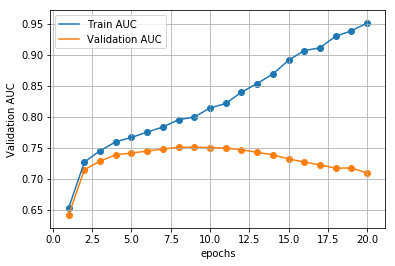

In [32]:
k = [i for i in range(1,len(auc_metric.cv_auc)+1)]
plt.plot(k,auc_metric.train_auc,label="Train AUC")
plt.scatter(k,auc_metric.train_auc)
plt.plot(k,auc_metric.cv_auc,label="Validation AUC")
plt.scatter(k,auc_metric.cv_auc)
plt.xlabel('epochs')
plt.ylabel('Validation AUC')
plt.grid()
plt.legend()
plt.show()

In [33]:
nn.load_weights('Model2.pkl')
score = nn.evaluate([test_sequence,x_test_new['state'],x_test_new['grade'],x_test_new['categories'],x_test_new['subcategories'],x_test_new['prefix'],x_test_new[['price','quantity','posted','resource']]],y_test_new,verbose=1,batch_size=2048)
y_test_hat = nn.predict([test_sequence,x_test_new['state'],x_test_new['grade'],x_test_new['categories'],x_test_new['subcategories'],x_test_new['prefix'],x_test_new[['price','quantity','posted','resource']]],verbose=1,batch_size=2048)

print("Test Accuracy",score[1])
print("Test loss",score[0])
print("Test AUC",roc_auc_score(y_test,y_test_hat[:,1]))

21850/21850 [==============================] - 10s 473us/step
Test Accuracy 0.8486041191513533
Test loss 0.44099990070820944
Test AUC 0.7465556724255022


<h3>Model 3 </h3>

In [8]:
# converting all categorical features into one-hot-encoding
from sklearn.feature_extraction.text import CountVectorizer

ohe1 = CountVectorizer()
ohe1.fit(x_train["teacher_prefix"].fillna("None").values)
x_train_prefix_ohe = ohe1.transform(x_train["teacher_prefix"].fillna("None").values)
x_cv_prefix_ohe = ohe1.transform(x_cv["teacher_prefix"].fillna("None").values)
x_test_prefix_ohe = ohe1.transform(x_test["teacher_prefix"].fillna("None").values)
print(x_train_prefix_ohe.shape)
print(x_cv_prefix_ohe.shape)
print(x_test_prefix_ohe.shape)

ohe2 = CountVectorizer()
ohe2.fit(x_train["school_state"].values)
x_train_state_ohe = ohe2.transform(x_train["school_state"].values)
x_cv_state_ohe = ohe2.transform(x_cv["school_state"].values)
x_test_state_ohe = ohe2.transform(x_test["school_state"].values)
print(x_train_state_ohe.shape)
print(x_cv_state_ohe.shape)
print(x_test_state_ohe.shape)

ohe3 = CountVectorizer(vocabulary = x_train["project_grade_category"].unique(),lowercase = False)
ohe3.fit(x_train["project_grade_category"].values)
x_train_grade_ohe = ohe3.transform(x_train["project_grade_category"].values)
x_cv_grade_ohe = ohe3.transform(x_cv["project_grade_category"].values)
x_test_grade_ohe = ohe3.transform(x_test["project_grade_category"].values)
print(x_train_grade_ohe.shape)
print(x_cv_grade_ohe.shape)
print(x_test_grade_ohe.shape)

ohe4 = CountVectorizer()
ohe4.fit(x_train["categories"].values)
x_train_categories_ohe = ohe4.transform(x_train["categories"].values)
x_cv_categories_ohe = ohe4.transform(x_cv["categories"].values)
x_test_categories_ohe = ohe4.transform(x_test["categories"].values)
print(x_train_categories_ohe.shape)
print(x_cv_categories_ohe.shape)
print(x_test_categories_ohe.shape)

ohe5 = CountVectorizer()
ohe5.fit(x_train["subcategories"].values)
x_train_subcategories_ohe = ohe5.transform(x_train["subcategories"].values)
x_cv_subcategories_ohe = ohe5.transform(x_cv["subcategories"].values)
x_test_subcategories_ohe = ohe5.transform(x_test["subcategories"].values)
print(x_train_subcategories_ohe.shape)
print(x_cv_subcategories_ohe.shape)
print(x_test_subcategories_ohe.shape)

(65548, 6)
(21850, 6)
(21850, 6)
(65548, 51)
(21850, 51)
(21850, 51)
(65548, 4)
(21850, 4)
(21850, 4)
(65548, 8)
(21850, 8)
(21850, 8)
(65548, 29)
(21850, 29)
(21850, 29)


In [14]:
#hstacking the columns
from scipy.sparse import hstack
other_train = hstack((x_train_prefix_ohe,x_train_state_ohe,x_train_grade_ohe,x_train_categories_ohe,x_train_subcategories_ohe,price_train,quantity_train,posted_train,num_train)).toarray()
other_cv = hstack((x_cv_prefix_ohe,x_cv_state_ohe,x_cv_grade_ohe,x_cv_categories_ohe,x_cv_subcategories_ohe,price_cv,quantity_cv,posted_cv,num_cv)).toarray()
other_test = hstack((x_test_prefix_ohe,x_test_state_ohe,x_test_grade_ohe,x_test_categories_ohe,x_test_subcategories_ohe,price_test,quantity_test,posted_test,num_test)).toarray()


print(other_train.shape)
print(other_cv.shape)
print(other_test.shape)

(65548, 102)
(21850, 102)
(21850, 102)


In [15]:
from keras.layers import Input,Embedding,Flatten,Dense,concatenate,LSTM,Dropout,Conv1D
from keras.models import Model

#text feature encoding
text_input = Input(shape=(600,))
text_embed = Embedding(vocab,300,weights=[embedding_matrix],trainable = False ,input_length=None)(text_input)
text_lstm = LSTM(100,input_shape=(600,300),activation='relu',return_sequences= True )(text_embed)
text_flatten = Flatten()(text_lstm)

# other than text features encoding
other_input = Input(shape=(102,1))
other_conv1 = Conv1D(100,kernel_size=5,activation='relu',padding='valid')(other_input)
other_conv2 = Conv1D(100,kernel_size=5,activation='relu',padding='valid')(other_conv1)
other_flatten = Flatten()(other_conv2)

concat = concatenate([text_flatten,other_flatten])
dense1 = Dense(309,activation='relu')(concat)
dropout1 = Dropout(0.7)(dense1)
dense2 = Dense(154,activation='relu')(dropout1)
dropout2 = Dropout(0.7)(dense2)
dense3 = Dense(77,activation='relu')(dropout2)
output = Dense(2,activation='softmax')(dense3)

nn = Model(input=[text_input,other_input],output=[output])
nn.summary()

W0829 19:04:24.509363 140633414264704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 19:04:24.557285 140633414264704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 19:04:24.567198 140633414264704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 19:04:24.579282 140633414264704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0829 19:04:24.580343 1406334142

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 600)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 102, 1)       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 600, 300)     14175300    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 98, 100)      600         input_2[0][0]                    
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [0]:
#how to use auc as metric in keras: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
# How to early stop if val_loss is increasing: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
#es = EarlyStopping(monitor='val_loss',mode='min',verbose = 1)
 
tensorboard =TensorBoard(log_dir="Model3")

import keras
import numpy as np
from sklearn.metrics import auc

#Using auc as metric: https://datascience.stackexchange.com/questions/13746/how-to-define-a-custom-performance-metric-in-keras/20192#20192
import sklearn.metrics as sklm
#How to get roc-auc curve:https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
# Create own earlystopping:https://stackoverflow.com/questions/37293642/how-to-tell-keras-stop-training-based-on-loss-value
class Metrics(keras.callbacks.Callback):
    def __init__(self,training_data):
      self.x = training_data[0]
      self.y = training_data[1]
      super(keras.callbacks.Callback, self).__init__()
      
      
    def on_train_begin(self, logs={}):
        self.cv_auc = []
        self.train_auc = []
        self.max_auc = -1
        
        
    def on_epoch_end(self, epoch, logs={}):
        train_score = np.asarray(self.model.predict(self.x,batch_size=2048,verbose=1))
        #train_predict = np.round(train_score)
        train_targ = self.y
        print("Train AUC score",sklm.roc_auc_score(train_targ,train_score))
        self.train_auc.append(sklm.roc_auc_score(train_targ,train_score))
        
        cv_score = np.asarray(self.model.predict(self.validation_data[:2],batch_size=2048,verbose=1))
        #cv_predict = np.round(cv_score)
        cv_targ = self.validation_data[2]
        print("Validation AUC score",sklm.roc_auc_score(cv_targ,cv_score))
        self.cv_auc.append(sklm.roc_auc_score(cv_targ,cv_score))
        
        if self.max_auc < self.cv_auc[-1]:
          temp = self.model.save_weights('Model3.pkl',overwrite=True)
          self.max_auc = self.cv_auc[-1]
          print("Changed")
        else:
          print("No change")
            
            #print("Epoch:",epoch,"EarlyStopped by CV_AUC")
            #self.model.stop_training = True

        return
      
auc_metric = Metrics(training_data=([train_sequence,other_train.reshape(65548,102,1)],y_train_new))

In [17]:
nn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
result = nn.fit([train_sequence,other_train.reshape(65548,102,1)],y_train_new,verbose=1,epochs=20,batch_size=2048,callbacks=[tensorboard,auc_metric],validation_data=([cv_sequence,other_cv.reshape(21850,102,1)],y_cv_new))

W0829 19:04:50.922564 140633414264704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0829 19:04:50.954940 140633414264704 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 65548 samples, validate on 21850 samples


W0829 19:04:53.335253 140633414264704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1122: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0829 19:04:53.336883 140633414264704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1125: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/20
65548/65548 [==============================] - 33s 496us/step
Train AUC score 0.6569317174894262
21850/21850 [==============================] - 11s 491us/step
Validation AUC score 0.6488942346928273
Changed
Epoch 2/20
65548/65548 [==============================] - 32s 495us/step
Train AUC score 0.7307021151888358
21850/21850 [==============================] - 11s 486us/step
Validation AUC score 0.7183453367394395
Changed
Epoch 3/20
65548/65548 [==============================] - 32s 491us/step
Train AUC score 0.7582216347540484
21850/21850 [==============================] - 11s 489us/step
Validation AUC score 0.7438334902226521
Changed
Epoch 4/20
65548/65548 [==============================] - 32s 493us/step
Train AUC score 0.772460920452646
21850/21850 [==============================] - 11s 498us/step
Validation AUC score 0.7541470008990228
Changed
Epoch 5/20
65548/65548 [==============================] - 32s 493us/step
Train AUC score 0.7815587598066527
21850/21850 [========

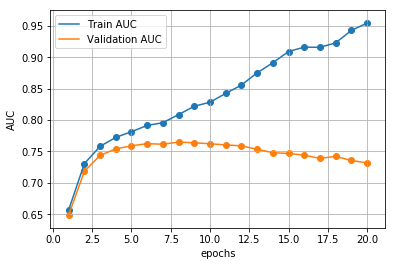

In [18]:
k = [i for i in range(1,len(auc_metric.cv_auc)+1)]
plt.plot(k,auc_metric.train_auc,label="Train AUC")
plt.scatter(k,auc_metric.train_auc)
plt.plot(k,auc_metric.cv_auc,label="Validation AUC")
plt.scatter(k,auc_metric.cv_auc)
plt.xlabel('epochs')
plt.ylabel('AUC')
plt.grid()
plt.legend()
plt.show()

In [19]:
nn.load_weights('Model3.pkl')
score = nn.evaluate([test_sequence,other_test.reshape(21850,102,1)],y_test_new,verbose=1,batch_size=2048)
y_test_hat = nn.predict([test_sequence,other_test.reshape(21850,102,1)],verbose=1,batch_size=2048)

print("Test Accuracy",score[1])
print("Test loss",score[0])
print("Test AUC",roc_auc_score(y_test,y_test_hat[:,1]))

21850/21850 [==============================] - 11s 492us/step
Test Accuracy 0.8486041191513533
Test loss 0.44320034540763437
Test AUC 0.7636837859002282


In [1]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model","Train Loss","Train Accuracy",'Train AUC','Test Loss','Test Accuracy','Test AUC']
x.add_row(['Model 1',0.2898,0.8486,0.8086,0.4212,0.8486,0.7521])
x.add_row(['Model 2',0.3673,0.8486,0.7995,0.4410,0.8486,0.7466])
x.add_row(['Model 3',0.3625,0.8486,0.8088,0.4432,0.8486,0.7637])
print(x)

+---------+------------+----------------+-----------+-----------+---------------+----------+
|  Model  | Train Loss | Train Accuracy | Train AUC | Test Loss | Test Accuracy | Test AUC |
+---------+------------+----------------+-----------+-----------+---------------+----------+
| Model 1 |   0.2898   |     0.8486     |   0.8086  |   0.4212  |     0.8486    |  0.7521  |
| Model 2 |   0.3673   |     0.8486     |   0.7995  |   0.441   |     0.8486    |  0.7466  |
| Model 3 |   0.3625   |     0.8486     |   0.8088  |   0.4432  |     0.8486    |  0.7637  |
+---------+------------+----------------+-----------+-----------+---------------+----------+
